## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

## 神經網路

In [5]:
from keras.layers import BatchNormalization, Dropout
from keras.regularizers import l2

def build_mlp(input_shape, 
              output_units=10, 
              num_neurons=[128,64,32], 
              drp_ratio=0.2, 
              L_ratio=0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, unit in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=unit,
                                  activation="relu",
                                  name="hidden_layer"+str(i+1),
                                  kernel_regularizer=l2(L_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=unit,
                                  activation="relu",
                                  name="hidden_layer"+str(i+1),
                                  kernel_regularizer=l2(L_ratio))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)

    output_layer = keras.layers.Dense(units=output_units,
                                      activation="softmax",
                                      name="output_layer")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

## 超參數

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 35
MOMENTUM = 0.95
BATCH_SIZE = 512
DRP_RATE = [0.10, 0.15, 0.25]
L_RATE=[1e-4, 1e-8, 1e-12]

## 訓練

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for drop in DRP_RATE:
    for L2 in L_RATE:        
        keras.backend.clear_session() # 把舊的 Graph 清掉
        
        print("")
        print("#"*40)
        print("Experiment with Drop_Ratio = %.2f" %(drop))
        print("Experiment with L2_Regularization = %.1e" %(L2))
        print("#"*40)
        
        model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=drop, L_ratio=L2)
        model.summary()

        opt = keras.optimizers.SGD(learning_rate=LEARNING_RATE, 
                                   momentum=MOMENTUM, 
                                   nesterov=True)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=opt)
        
        model.fit(x_train, y_train,
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
    
        exp_name_tag = "exp-Drop-%s-L2-%s" %(str(drop), str(L2))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


########################################
Experiment with Drop_Ratio = 0.10
Experiment with L2_Regularization = 1.0e-04
########################################
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (

Train on 50000 samples, validate on 10000 samples
Epoch 1/35
50000/50000 [==============================] - 8s 155us/step - loss: 2.2691 - accuracy: 0.2327 - val_loss: 2.1041 - val_accuracy: 0.2130
Epoch 2/35
50000/50000 [==============================] - 5s 98us/step - loss: 1.9275 - accuracy: 0.3162 - val_loss: 1.8454 - val_accuracy: 0.3567
Epoch 3/35
50000/50000 [==============================] - 6s 119us/step - loss: 1.8339 - accuracy: 0.3491 - val_loss: 1.7533 - val_accuracy: 0.3771
Epoch 4/35
50000/50000 [==============================] - 4s 83us/step - loss: 1.7776 - accuracy: 0.3700 - val_loss: 1.6954 - val_accuracy: 0.4100
Epoch 5/35
50000/50000 [==============================] - 5s 105us/step - loss: 1.7337 - accuracy: 0.3830 - val_loss: 1.6731 - val_accuracy: 0.4060
Epoch 6/35
50000/50000 [==============================] - -8s -158us/step - loss: 1.6983 - accuracy: 0.3982 - val_loss: 1.6262 - val_accuracy: 0.4256
Epoch 7/35
50000/50000 [==============================] - 5s 1

50000/50000 [==============================] - 4s 78us/step - loss: 1.6675 - accuracy: 0.4093 - val_loss: 1.5960 - val_accuracy: 0.4297
Epoch 8/35
50000/50000 [==============================] - 4s 77us/step - loss: 1.6412 - accuracy: 0.4170 - val_loss: 1.5792 - val_accuracy: 0.4357
Epoch 9/35
50000/50000 [==============================] - 4s 79us/step - loss: 1.6210 - accuracy: 0.4259 - val_loss: 1.5521 - val_accuracy: 0.4485
Epoch 10/35
50000/50000 [==============================] - 5s 106us/step - loss: 1.6046 - accuracy: 0.4324 - val_loss: 1.5779 - val_accuracy: 0.4352
Epoch 11/35
50000/50000 [==============================] - 4s 88us/step - loss: 1.5882 - accuracy: 0.4361 - val_loss: 1.5393 - val_accuracy: 0.4492
Epoch 12/35
50000/50000 [==============================] - 4s 79us/step - loss: 1.5712 - accuracy: 0.4425 - val_loss: 1.5315 - val_accuracy: 0.4571
Epoch 13/35
50000/50000 [==============================] - 4s 87us/step - loss: 1.5598 - accuracy: 0.4453 - val_loss: 1.5456 

Epoch 14/35
50000/50000 [==============================] - 4s 78us/step - loss: 1.6340 - accuracy: 0.4302 - val_loss: 1.5735 - val_accuracy: 0.4580
Epoch 15/35
50000/50000 [==============================] - 4s 80us/step - loss: 1.6267 - accuracy: 0.4351 - val_loss: 1.5688 - val_accuracy: 0.4548
Epoch 16/35
50000/50000 [==============================] - 5s 97us/step - loss: 1.6132 - accuracy: 0.4381 - val_loss: 1.5892 - val_accuracy: 0.4528
Epoch 17/35
50000/50000 [==============================] - 8s 157us/step - loss: 1.5992 - accuracy: 0.4460 - val_loss: 1.5392 - val_accuracy: 0.4684
Epoch 18/35
50000/50000 [==============================] - 5s 95us/step - loss: 1.5932 - accuracy: 0.4470 - val_loss: 1.5506 - val_accuracy: 0.4643
Epoch 19/35
50000/50000 [==============================] - 4s 79us/step - loss: 1.5807 - accuracy: 0.4514 - val_loss: 1.5435 - val_accuracy: 0.4668
Epoch 20/35
50000/50000 [==============================] - 4s 79us/step - loss: 1.5734 - accuracy: 0.4513 - val

Epoch 21/35
50000/50000 [==============================] - 5s 94us/step - loss: 1.5283 - accuracy: 0.4545 - val_loss: 1.5240 - val_accuracy: 0.4518
Epoch 22/35
50000/50000 [==============================] - 5s 92us/step - loss: 1.5228 - accuracy: 0.4571 - val_loss: 1.4996 - val_accuracy: 0.4648
Epoch 23/35
50000/50000 [==============================] - 5s 107us/step - loss: 1.5157 - accuracy: 0.4584 - val_loss: 1.4839 - val_accuracy: 0.4718
Epoch 24/35
50000/50000 [==============================] - 5s 103us/step - loss: 1.5062 - accuracy: 0.4650 - val_loss: 1.4724 - val_accuracy: 0.4769
Epoch 25/35
50000/50000 [==============================] - 4s 79us/step - loss: 1.4974 - accuracy: 0.4656 - val_loss: 1.4588 - val_accuracy: 0.4770
Epoch 26/35
50000/50000 [==============================] - 4s 87us/step - loss: 1.4893 - accuracy: 0.4660 - val_loss: 1.4535 - val_accuracy: 0.4844
Epoch 27/35
50000/50000 [==============================] - 4s 79us/step - loss: 1.4872 - accuracy: 0.4685 - va

Epoch 28/35
50000/50000 [==============================] - 4s 78us/step - loss: 1.4973 - accuracy: 0.4647 - val_loss: 1.4650 - val_accuracy: 0.4732
Epoch 29/35
50000/50000 [==============================] - 4s 78us/step - loss: 1.4934 - accuracy: 0.4683 - val_loss: 1.4816 - val_accuracy: 0.4717
Epoch 30/35
50000/50000 [==============================] - 4s 78us/step - loss: 1.4879 - accuracy: 0.4684 - val_loss: 1.4614 - val_accuracy: 0.4795
Epoch 31/35
50000/50000 [==============================] - 4s 81us/step - loss: 1.4828 - accuracy: 0.4702 - val_loss: 1.4476 - val_accuracy: 0.4909
Epoch 32/35
50000/50000 [==============================] - 4s 80us/step - loss: 1.4704 - accuracy: 0.4748 - val_loss: 1.4494 - val_accuracy: 0.4877
Epoch 33/35
50000/50000 [==============================] - 4s 80us/step - loss: 1.4651 - accuracy: 0.4771 - val_loss: 1.4641 - val_accuracy: 0.4847
Epoch 34/35
50000/50000 [==============================] - 4s 81us/step - loss: 1.4602 - accuracy: 0.4792 - val_

Epoch 35/35
50000/50000 [==============================] - 4s 83us/step - loss: 1.5866 - accuracy: 0.4492 - val_loss: 1.5090 - val_accuracy: 0.4766

########################################
Experiment with Drop_Ratio = 0.25
Experiment with L2_Regularization = 1.0e-08
########################################
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer2 

Train on 50000 samples, validate on 10000 samples
Epoch 1/35
50000/50000 [==============================] - 6s 126us/step - loss: 2.4881 - accuracy: 0.1951 - val_loss: 2.1245 - val_accuracy: 0.2191
Epoch 2/35
50000/50000 [==============================] - 4s 80us/step - loss: 2.0920 - accuracy: 0.2746 - val_loss: 1.8885 - val_accuracy: 0.3319
Epoch 3/35
50000/50000 [==============================] - 4s 78us/step - loss: 1.9839 - accuracy: 0.3019 - val_loss: 1.8028 - val_accuracy: 0.3646
Epoch 4/35
50000/50000 [==============================] - 4s 79us/step - loss: 1.9108 - accuracy: 0.3209 - val_loss: 1.7626 - val_accuracy: 0.3749
Epoch 5/35
50000/50000 [==============================] - 4s 79us/step - loss: 1.8641 - accuracy: 0.3379 - val_loss: 1.7137 - val_accuracy: 0.3917
Epoch 6/35
50000/50000 [==============================] - 4s 79us/step - loss: 1.8369 - accuracy: 0.3450 - val_loss: 1.6789 - val_accuracy: 0.4056
Epoch 7/35
50000/50000 [==============================] - 4s 79us/s

## 實驗結果視覺化 

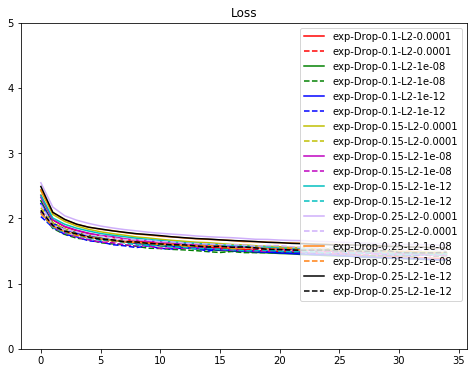

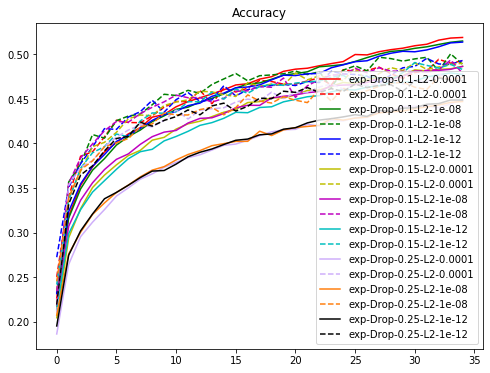

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "c", "xkcd:pale violet", "tab:orange","k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

# 心得：
- L2越小，Loss越小。
- 隨著epochs增大，「Drop較大的」預測精準度有機會與「Drop較小的」黃金交叉。
- Drop較大的valid比train的精準度來得高，Drop較小的則相反。

Drop的應該設定多少比例沒有一定的答案，我認為應該根據訓練數據集的大小來決定。